In [492]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sympy as sp

from astropy import units as u
from matplotlib import pyplot as plt
from scipy.integrate import quad
from scipy.optimize import approx_fprime

from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(70, 0.3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [493]:
# model consts
h70=1
P0=6.85
c500=1.09
gamma=0.31
alpha=1.07
beta=5.46

gamma_b=4./3.

In [494]:
def E(z): #ratio of the Hubble constant at redshift z to its present value
    return cosmo.H(z)/cosmo.H(0)

In [495]:
def P500(z, M500):
    M500=M500.to(u.Msun)
    return ((1.65*1e-3*E(z)**(8/3)
            *(M500/(3*1e14*h70**(-1)*u.Msun))**2/3 
            *h70**2 * u.keV * u.cm**-3)).to(u.erg/u.cm**3, equivalencies=u.mass_energy()) 

In [496]:
def Pg(x, z, M500): #x=r/r500
    return (P0*P500(z, M500) #units keVcm-3
           / ((c500*x)**gamma  #unitless
              * (1+ (c500*x)**alpha)**((beta-gamma)/alpha))).to(u.erg/u.cm**3, equivalencies=u.mass_energy())

def Pg_r(r, z, M500, R500):
    return Pg(r/R500, z, M500).value

Text(0, 0.5, 'Pg (erg/cm3)')

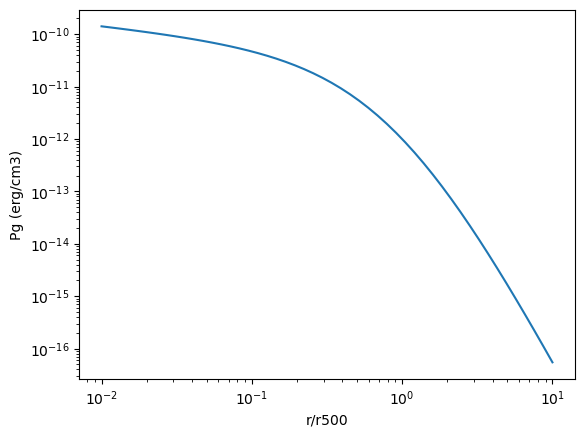

In [502]:
x=np.logspace(-2, 1)
z=3, 
M500=1e14*u.Msun
plt.loglog(x, Pg(x, z, M500).to(u.erg*u.cm**-3))
plt.xlabel('r/r500')
plt.ylabel('Pg (erg/cm3)')

Text(0, 0.5, 'dP/dr (erg/(cm3 Mpc))')

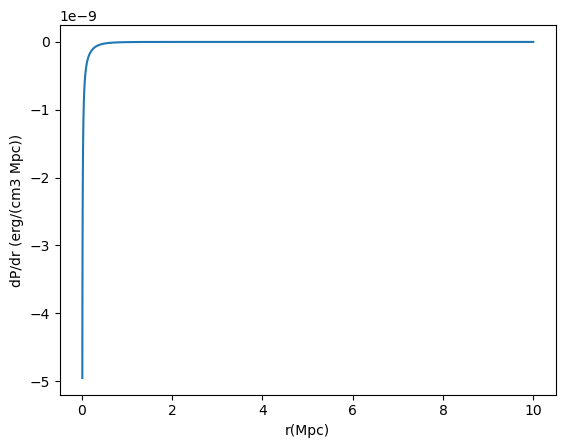

In [501]:
#r=np.logspace(-2, 1)*R500
x_vals=np.logspace(-2, 1)
rs=x_vals*R500
plt.plot(rs, [dP_dr(r, R500, M500, z) for r in rs])
plt.xlabel('r(Mpc)')
plt.ylabel('dP/dr (erg/(cm3 Mpc))')

In [503]:
def dP_dr(r, R500, M500, z):
    R500=R500.to(u.Mpc).value
    gradients=approx_fprime(r, lambda r: Pg_r(r, z, M500, R500))
    return np.array(gradients)*u.erg/(u.cm**3 * u.Mpc)
    
def integrand(r, R500, M500, z, r0, rc):
    r=r*u.Mpc
    x=r/R500
    integrand=(((Pg(x, z, M500))**((gamma_b-1)/gamma_b)).to(u.erg**(1/4)*u.cm**(-3/4))
               *(1/Pg(x, z, M500)).to(u.cm**3/u.erg) 
               #*np.array([dP_dr([rad.value], R500, M500, z).to(u.erg*u.cm**(-3)*u.Mpc**(-1)) for rad in rs]) 
               *dP_dr(r.value, R500, M500, z)
               *(1-np.exp(-1*r/r0)).to(1)
               *(np.exp(-1*r/rc)).to(1))
    return integrand.to(u.erg**(1/4) * u.cm**(-3/4) *u.Mpc**(-1)).value
    
def q(R500, M500, z, r0, rc):
    rini=0.015*R500.to(u.Mpc).value
    rmax=R500.to(u.Mpc).value
    integral, _ = quad(integrand, rini, rmax, args=(R500, M500, z, r0, rc))
    return integral*(u.erg**(1/4) * u.cm**(-3/4))

In [504]:
def h(Linj, r, r0, rc, q):
    return (Linj/(4*np.pi*r**2)
            *(1-np.exp(-1*r/r0))
            *np.exp(-1*r/rc)
            *(1/q))

In [512]:
def vol_heating_rate(r, R500, M500, z, Linj, rc):
    x=r/R500
    r0=(0.015*R500).to(u.cm)
    return (h(Linj, r, r0, rc, q(R500, M500, z, r0, rc))
        *(Pg(x, z, M500))**((gamma_b-1)/gamma_b)
        *(1/r)
        *(r/Pg(x, z, M500))    
        *dP_dr([r.to(u.Mpc).value], R500, M500, z)).to(u.erg/(u.s*u.cm**3)) 

In [509]:
R500=1*u.Mpc
M500=2e14*u.Msun
z=0
rc=0.1*R500.to(u.cm)
Linj=7e44*u.erg/u.s
#rini=0.015*R500.to(u.Mpc).value
rmax=R500.to(u.Mpc).value

In [513]:
eps_01=[vol_heating_rate(r, R500, M500, z, Linj, rc) for r in rs]

In [515]:
eps_03=[vol_heating_rate(r, R500, M500, z, Linj, 0.3*R500) for r in rs]

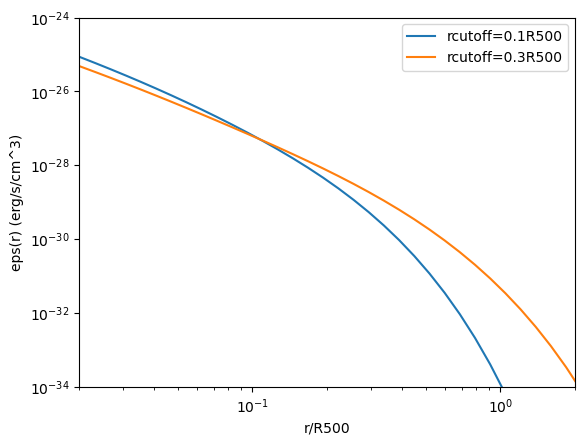

In [523]:
x_vals=np.logspace(-2, 1)
rs=x_vals*R500
plt.loglog(x_vals, eps_01, label='rcutoff=0.1R500')
plt.loglog(x_vals, eps_03, label='rcutoff=0.3R500')
plt.xlabel('r/R500')
plt.ylabel('eps(r) (erg/s/cm^3)')
plt.xlim(2*1e-2, 2*1e0)
plt.ylim(1e-34, 1e-24)
plt.legend()

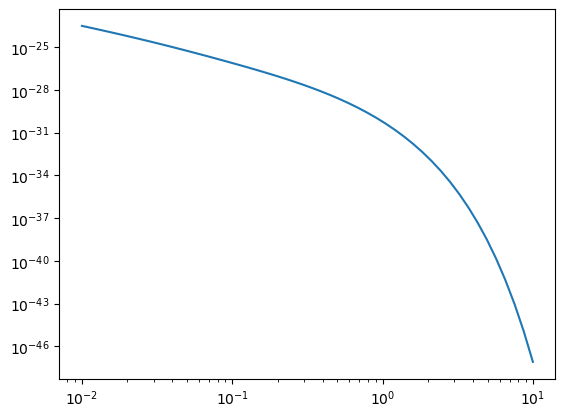

In [522]:
plt.loglog(x_vals, eps_03*R500**3*4*np.pi, label='rcutoff=0.1R500')
plt.scatter(10, 2*)

In [529]:
vhr=eps_03[25]
(vhr*R500**3).to(u.erg/u.s)

<Quantity [3.25993233e+44] erg / s>

In [535]:
vhr=eps_03[33]
(vhr*R500**3).to(u.erg/u.s)

<Quantity [1.01933988e+42] erg / s>